# OpenAI Whisper using FastAPI
______________________________

## Introduction
______________________________

In this tutorial, we're going to walk through how we created and deployed an API for the [OpenAI Whisper LLM model](https://openai.com/research/whisper) with BlindBox. 

The Whisper model performs transcription of audio files. By deploying the Whisper model with BlindBox, users' audio files and transcriptions remain confidential at all times and are not exposed to the service provider! 

Preparing and deploying an application with BlindBox can be broken down into four stages:

[IMAGE HERE]

In this tutorial, we are primarily going to focus on the first step: Preparing the application image.

We will split this into two sub-steps:

1. How we **created a BlindBox-compatible API** for the model.
2. How we **created the Docker image** for our API.

Once we have covered this step, we will provide a quick demonstration of how to deploy and query the application image.

> You can see how we deploy the image with BlindBox in the [Quick tour](https://blindbox.mithrilsecurity.io/en/latest/docs/getting-started/quick-tour/).

Let's dive in!

## Pre-requisites
____________________

To follow along with this tutorial, you will need to:

+ Have Docker installed in your environment. Here's the [Docker installation guide](https://docs.docker.com/desktop/install/linux-install/).
+ Have [blindbox](https://pypi.org/project/blindbox/), [terraform](https://www.terraform.io/) and the [Azure CLI tool](https://learn.microsoft.com/en-us/cli/azure/install-azure-cli) installed.

In [ ]:
# install blindbox & blindbox CLI
!pip install blindbox[cli]

# Download terraform
!wget -O- https://apt.releases.hashicorp.com/gpg | sudo gpg --dearmor -o /usr/share/keyrings/hashicorp-archive-keyring.gpg

# Add terraform to trusted apt packages
!echo "deb [signed-by=/usr/share/keyrings/hashicorp-archive-keyring.gpg] https://apt.releases.hashicorp.com $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/hashicorp.list

# Install terraform
!sudo apt update && sudo apt install terraform

# Install azure-cli
!curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash

## Packaging Whisper with FastAPI
_______________________

Our first task in deploying the **Whisper OpenAI** model with **BlindBox** was to create an API so that our end users will be able to query the model. We did this using the **FastAPI library** which allows us to quickly assign functions to API endpoints.
 
The full code we use to do this is available in the `server.py` file in the `ai_server_example` folder on BlindBox's official GitHub repository.

In [ ]:
!git clone https://github.com/mithril-security/blindbox
!cd ai_server_example

There are three key sections in this code:

### Initial set-up

Firstly, we load the OpenAI tiny English Whisper model from Hugging Face, and initialize our API.

```python

 # Some settings
STT = "openai/whisper-tiny.en" # Model name (HuggingFace)
MODEL_STORE_ADDR = "172.17.0.1" # Address of the model store

 # Initialize our FastAPI API object
app = FastAPI()

 # Load model and tokenizer
whisper_processor = load_from_store(STT, WhisperProcessor, MODEL_STORE_ADDR)
whisper_model = load_from_store(STT, WhisperForConditionalGeneration, MODEL_STORE_ADDR)
whisper_model.eval()
```

### Creating an endpoint

Secondly, we create a `/whisper/predict` POST endpoint on our FastAPI application object. This endpoint will convert the audio file to a tensor and then query the model with our input data.

```python
 # This is a POST endpoint located at /whisper/predict
@app.post("/whisper/predict")
@async_speech_to_text_endpoint(sample_rate=16000) # We use the async_speech_to_text_endpoint to handle conversion from an audio file to a tensor

async def predict(x: np.ndarray) -> str:
    
    input_features = whisper_processor(
        x, sampling_rate=16000, return_tensors="pt"
    ).input_features
    
    # We query the model through the runner
    predicted_ids = await whisper_runner.submit(input_features)
    
    # We decode our results
    transcription = whisper_processor.batch_decode(
        predicted_ids, skip_special_tokens=True
    )

    return transcription[0]
```

We created a runner for querying the model which uses adaptive batching and a separate thread to avoid blocking the event loop since this process is quite intensive.

The runner is launched when the server starts up and executes the `run_whisper` function when a batch is ready to be processed.

```python
 # A function that wraps prediction code and that will be executed by the runner
def run_whisper(x: torch.Tensor) -> torch.Tensor:
    return whisper_model.generate(x, max_length=128)


 # Define a runner (i.e. the given function will be run on a separate thread with adaptive batching)
whisper_runner = BatchRunner(
    run_whisper,
    max_batch_size=256,
    max_latency_ms=200,
    collator=TorchCollator(),
)

app.on_event("startup")(whisper_runner.run) # Schedule the runner to run when the server is up
```

### Launching our server

Finally, we deploys our API on a python ASGI `uvicorn` server (an asynchronous web server) on `port 80`. It is essential to use **port 80** as BlindBox will need to be able to communicate with our application on this port!

```python
if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=80)

```

To sum up, we packaged the Whisper model as an API by doing the following:

+ Creating an API app object that "configures" the `uvicorn` server by providing handlers for specific endpoints

+ Creating a `whisper/predict` endpoint which in turn queries the Whisper model.

+ Deploy our API on our server on `port 80`.

## Packaging our application in a Docker image
________________________________

Once we had created out Whisper API, all that was left to do was create a **Docker image** for our application that could then be deployed in BlindBox. Let's take a look at the Dockerfile we used to do this:

```docker
FROM python:3.10.10-bullseye as base

 # install necessary dependencies
RUN pip install \
    torch==1.13.1 \
    transformers==4.26.1 \
    fastapi==0.95.0 \
    python-multipart==0.0.6 \
    uvicorn==0.21.1 \
    soundfile==0.12.1 \
    messages \
    librosa==0.10.0 \
    pydantic==1.10.7 \
    requests==2.28.2 \
    --extra-index-url https://download.pytorch.org/whl/cpu

COPY batch_runner.py /
COPY collators.py /
COPY messages.py /
COPY model_store.py /
COPY serializers.py /
COPY server.py /

 # signal our app runs on port 80
EXPOSE 80

 # launch our server
CMD ["python server.py"]
```

> Same as for the application code, this file can be viewed in the `ai_server_example` folder on the official BlindBox GitHub repository.

There are no complex requirements for the Docker image, but it is recommended to `EXPOSE` port 80 to signal that the application will be running on port 80 within our BlindBox.

## Deploying our application

We explain how to get everything set-up in order to deploy applications with BlindBox in more detail our [Quick Tour](../../docs/docs/getting-started/quick-tour.ipynb).

Here, we will take a brief look at the code we used to deploy our BlindBox on a system which already had all the pre-requisites set-up.

In [ ]:
# download and navigate to whisper example folder
!git clone https://github.com/mithril-security/blindbox
!cd examples/whisper

In [ ]:
# initialize the blindbox
!blindbox --platform azure-sev init

# build whisper application assigning it the tag "myimage"
!docker build -t whisper .

# deploy our image inside Confidential VM using BlindBox
!blindbox deploy whisper-blindbox:v1

> Note that when we launch `blindbox deploy`, we will see details about the Azure resources that will be created by the process and must input 'yes' in order to complete deployment.

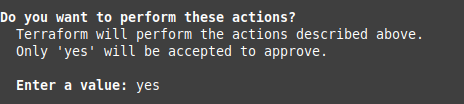

When this process is complete, you will see the following success message.

## Querying our application

We were then able to query our Whisper application within our Confidential BlindBox. The code we send to the application is protected from outside access at every step of its journey!

To query the model, we used the same [test audio file](https://www2.cs.uic.edu/~i101/SoundFiles/taunt.wav) provided by University of Illinois at Chicago as detailed in the Quick Tour!

In [ ]:
# Download our example audio file and save it as `test.wav` in a `.tmp` folder

!mkdir -p .tmp
!wget https://www2.cs.uic.edu/~i101/SoundFiles/taunt.wav -O .tmp/test.wav

In [ ]:
# import requests module
from blindbox  import requests

CONFIDENTIAL_VM_IP_ADDRESS = "127.0.0.1:80" # replace with your VM IP address and port

# we query our application, sending it our audio file
res = requests.post(url=f"http://{CONFIDENTIAL_VM_IP_ADDRESS}/whisper/predict", files={"audio": open(".tmp/test.wav", "rb")})

# display result
print(res)

We get back a string containing the transcription of our audio file!

## Conclusions
_______________________

The Whisper app is now ready to be built and deployed on BlindBox! You can see exactly how we do this in our [Quick Tour](https://blindbox.mithrilsecurity.io/en/latest/docs/getting-started/quick-tour/).
 
In this tutorial, we've seen how we can:
+ Create a **BlindBox-compatible application**
+ Create an **application image**, ready to be built and deployed on BlindBox!